# Analysis of Brain Tumor Segmentation: Leveraging KNN, SVM & Random Forest


Under the supervision of:
- Prof. Inas Yassine
- Eng. Merna Atef

Team Members :

| Team Members | Sec | BN |
|---|---|---|
| Ibrahim Mohamed Ibrahim | 1|2|
| Rawan Mohamed Fekry | 1 | 34|
| Kamel Mohamed Zaghloul | 2 | 10|
| Youssef Shaaban Mohammed | 2 | 56|





## Project Data

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor:
 1. Meningioma (708 slices).
 2. Glioma (1426 slices).
 3. Pituitary Tumor (930 slices).

Each slice is an grayscale image of 512x512 pixels.



### 1- Import Libraries

In [ ]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.feature import hog

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score ,roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize


### 2- Load dataset from kaggle

In [ ]:
## to get the data first add kaggle.json to colab
## you can get this file from Settings -> API -> create new token

! pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d denizkavi1/brain-tumor
!mkdir data
!unzip brain-tumor.zip -d data

### 3- open data and save it into numpy array

In [ ]:
path = "/content/data"
classes = ["meningioma", "glioma", "pituitary"]

counter = 0
X = np.zeros( ( 3064, 40000 ) )
Y = np.zeros( ( 3064 ) )

for idx, Class in enumerate( classes ):
  folderPath = os.path.join( path, str( idx + 1 ) )

  for fileName in os.listdir( folderPath ):
    img = cv.imread( os.path.join( folderPath, fileName ), cv.IMREAD_GRAYSCALE)
    img = cv.resize( img, (200, 200) )
    img = img.reshape(-1)
    X[counter] = img
    Y[counter] = idx + 1
    counter+=1;


### 4- Show some examples

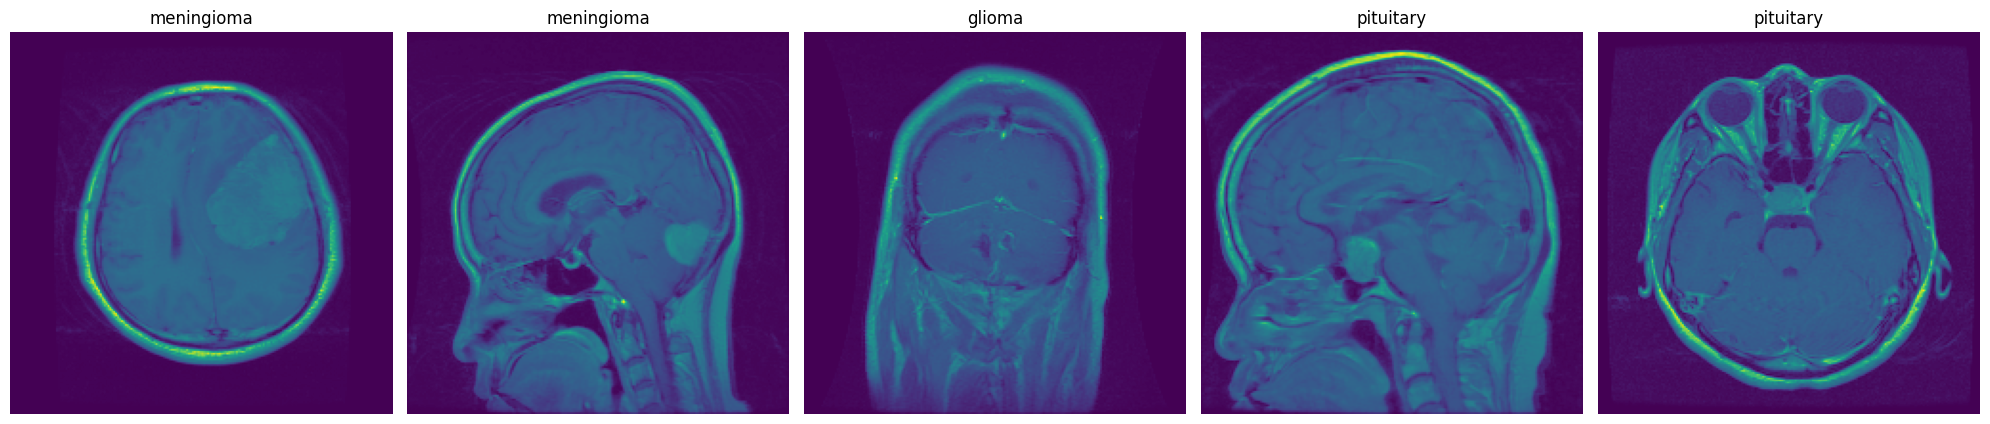

In [ ]:
images_idx = [0, 100, 1500, 2300, 3000]

def plotImages(X, indexes):
  fig, axes = plt.subplots(nrows=1, ncols= len(images_idx) , figsize=(20, 5))
  for i in range(len(images_idx)):
    axes[i].imshow( X[ indexes[i] ].reshape( (200, 200) ) )
    axes[i].set_title( classes[ int( Y[ indexes[i] ] ) - 1 ])
    axes[i].axis("off")

  plt.tight_layout()


plotImages(X, images_idx)


## Preprocessing

Before use the data with any ML model, preprocessing needed first, the proposed methods to process data:

### 1- Remove noise outside the skull

this step is essential, as it will affect next steps, and the simple algorithm for this is to just binarize image using otsu, then mask original image with binarized image.

In [ ]:
class NoiseRemoval(BaseEstimator, TransformerMixin):

  def fit(self, X, y = None):
    return self

  def transform(self, X):

    def removeNoiseImg(row):
      img = row.reshape((200, 200))
      threshold = threshold_otsu(img)
      mask = img > threshold
      masked_image = cv.bitwise_and(img, img, mask=mask.astype(np.uint8))
      masked_image = masked_image.reshape(-1)
      return masked_image

    return np.apply_along_axis(removeNoiseImg, axis=1, arr=X)


  def fit_transform(self, X, y = None):

    return self.transform(X)

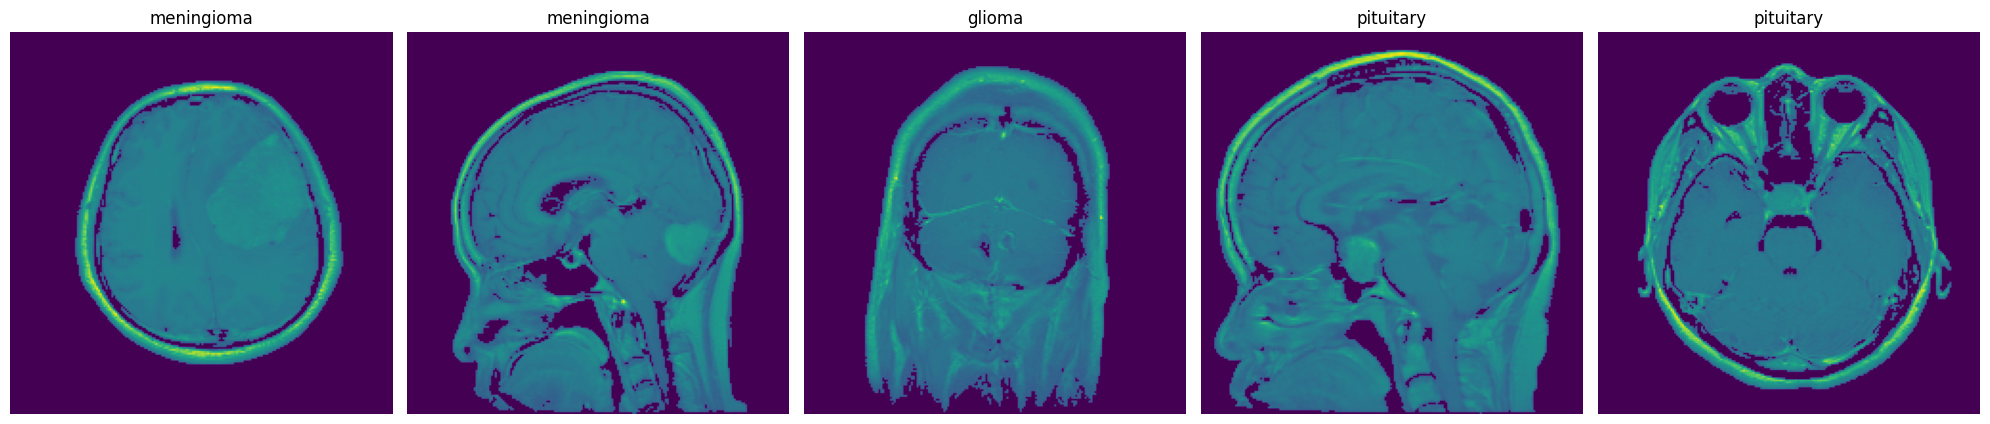

In [ ]:
noise = NoiseRemoval()

X_cleaned = noise.fit_transform(X)

plotImages(X_cleaned, images_idx)

### 2- Contrast Enhancment
to make tumor more clear, histogram equalization can be used to enhance the contrast of the image.

In [ ]:
class ConstrastEnhancer(BaseEstimator, TransformerMixin):

  def fit(self, X, y = None):
    return self

  def transform(self, X):

    def constrastEnhancerImg(row):
      img = row.reshape((200, 200)).astype(np.uint8)
      equalized = cv.equalizeHist(img)
      equalized = equalized.reshape(-1)
      return equalized

    return np.apply_along_axis(constrastEnhancerImg, axis=1, arr=X)


  def fit_transform(self, X, y = None):

    return self.transform(X)

the difference between using constrast enhancer with and without noise removal

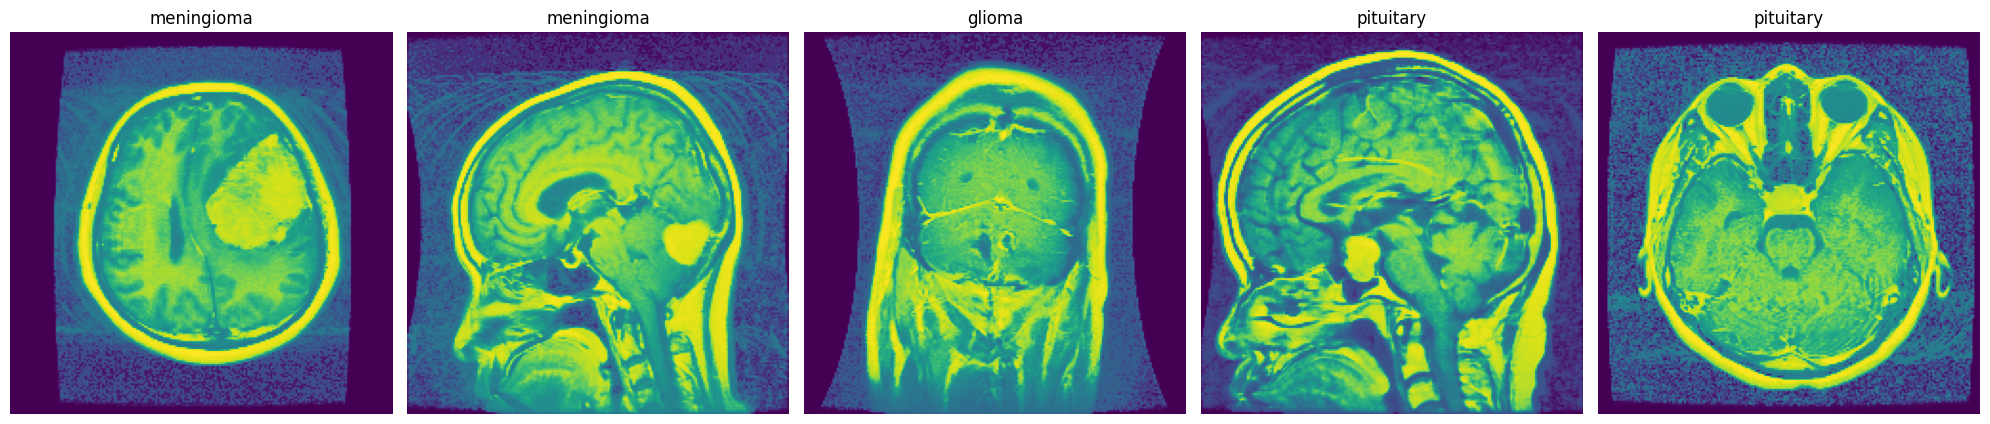

In [ ]:
## Without Noise Removal
enhancer = ConstrastEnhancer()
X_enhanced = enhancer.fit_transform(X)

plotImages(X_enhanced, images_idx)


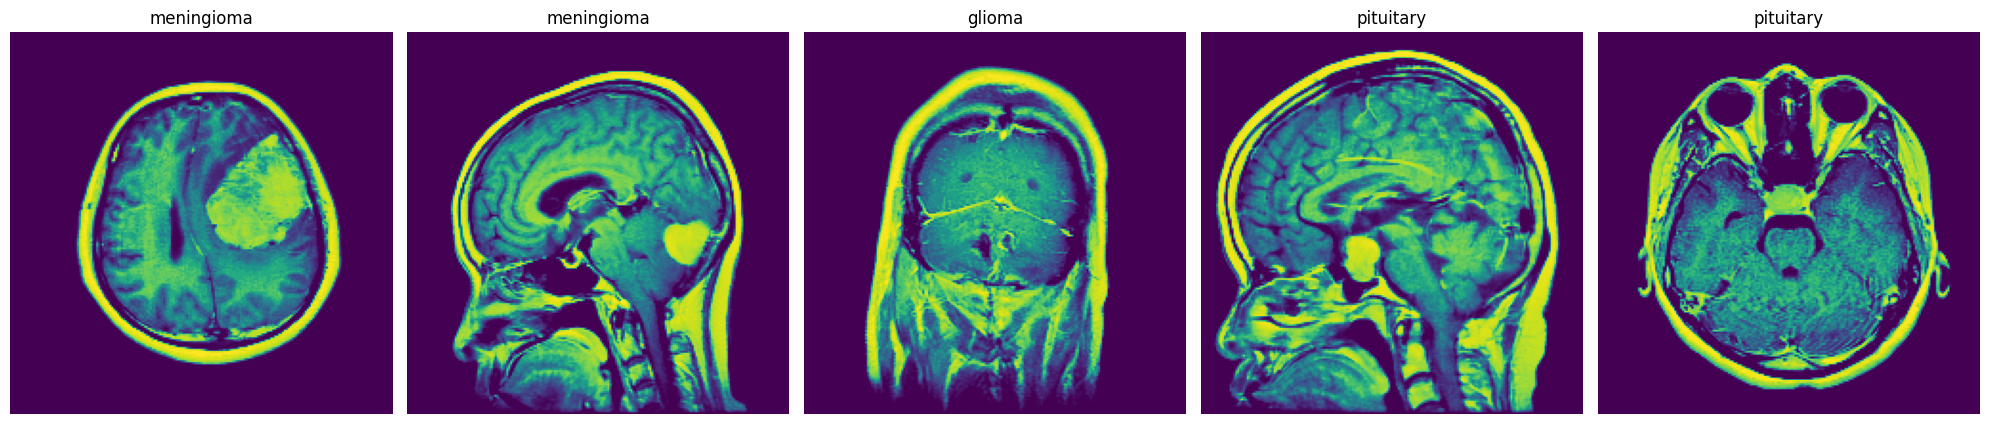

In [ ]:
## With Noise Removal

pipeline = Pipeline([
    ('noise_removal', NoiseRemoval()),
    ('contrast_enhancer', ConstrastEnhancer()),
])

X_transfromed = pipeline.fit_transform(X)
plotImages(X_transfromed, images_idx)

### 3- Skull Stripping (Optional)
to analyse brain tissues, skull bones, fats and any thing except tissues must be removed, so the technique used here is morphological operations, using opening and closing filters to remove the skull bones.
- this technique did't work perfectly and a better approach is using U-Net to segment brain tissues.

In [ ]:
class SkullStripper(BaseEstimator, TransformerMixin):

  def fit(self, X, y = None):
    return self

  def transform(self, X):

    def SkullStrippingImg(row):
      img = row.reshape( (200, 200) )
      mask = img > 0
      opened_image = morphology.opening( mask, morphology.square(13) )
      closed_image = morphology.closing( opened_image,  morphology.square(21) )
      masked_image = cv.bitwise_and( img, img, mask = closed_image.astype(np.uint8) )
      masked_image = masked_image.reshape(-1)

      return masked_image

    return np.apply_along_axis(SkullStrippingImg, axis=1, arr=X)


  def fit_transform(self, X, y = None):

    return self.transform(X)

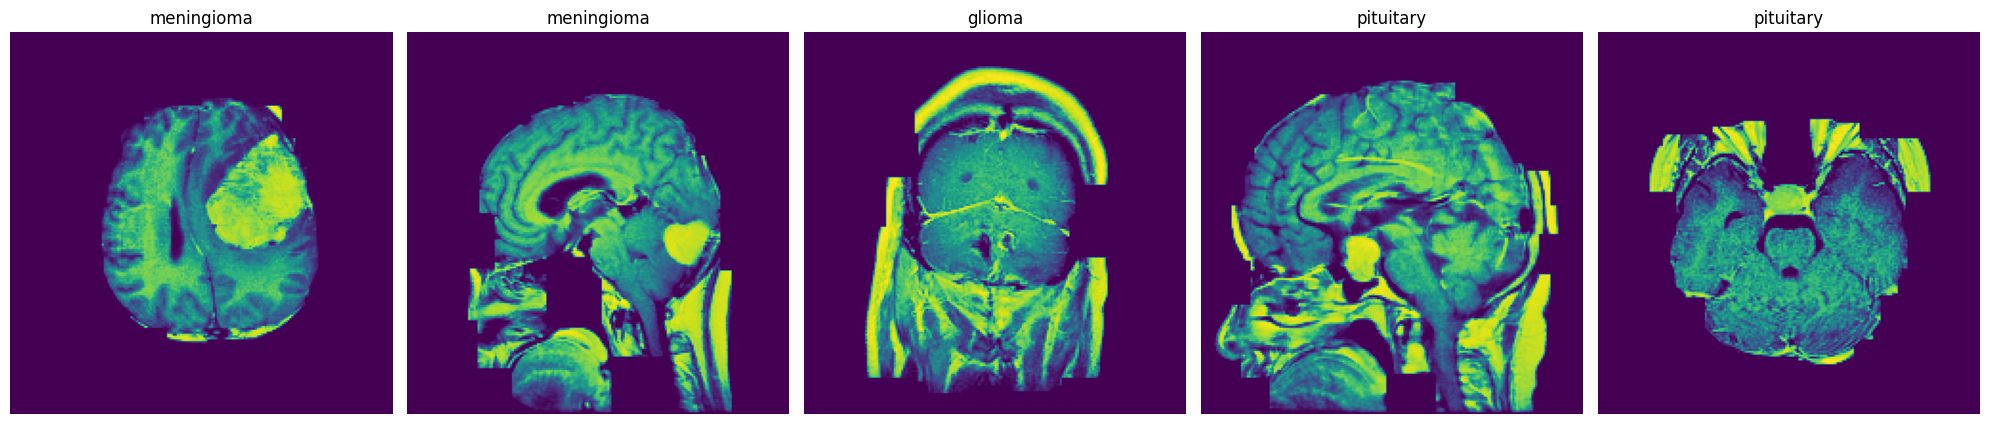

In [ ]:
pipeline = Pipeline([
    ('noise_removal', NoiseRemoval()),
    ('contrast_enhancer', ConstrastEnhancer()),
    ('skull_stripper', SkullStripper())
])

X_transfromed = pipeline.fit_transform(X)
plotImages(X_transfromed, images_idx)

as showen above, our technique of skull stripping has a greate potiental, but with some images it messed up the image, and make desicion harder for the model.

### 4- HOG Descriptors
HOG is a good way to extract features from images, and using this features in ML model to predict the output.

In [ ]:
class HogTransform(BaseEstimator, TransformerMixin):

  def fit(self, X, y = None):
    return self

  def transform(self, X):

    def HogImg(row):
      img = row.reshape( (200, 200) )
      hog_features = hog(img)

      return hog_features

    return np.apply_along_axis(HogImg, axis=1, arr=X)


  def fit_transform(self, X, y = None):

    return self.transform(X)

## Model Selection and Hyperparameters Turning
the proposed models that can be used is:
- Random forest
- SVM
- KNN


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle=True, stratify=Y)


param_grid = {
    'classifier': [SVC(), RandomForestClassifier(), KNeighborsClassifier() ],
    'skull_stripper':[None, SkullStripper()]
}

pipeline = Pipeline([
    ('noise_removal', NoiseRemoval()),
    ('contrast_enhancer', ConstrastEnhancer()),
    ('skull_stripper', SkullStripper()),
    ('hog_transform', HogTransform()),
    ('pca', PCA(n_components = 0.95)),
    ('classifier', SVC())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('noise_removal', NoiseRemoval()),
                                       ('contrast_enhancer',
                                        ConstrastEnhancer()),
                                       ('skull_stripper', SkullStripper()),
                                       ('hog_transform', HogTransform()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('classifier', SVC())]),
             param_grid={'classifier': [SVC(), RandomForestClassifier(),
                                        KNeighborsClassifier()],
                         'skull_stripper': [None, SkullStripper()]})

In [ ]:
grid_search.best_params_

{'classifier': KNeighborsClassifier(), 'skull_stripper': None}

so the best classifier is KNN, we need now to hypertune it, to get the best performance.

In [ ]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9 ],
    'classifier__p': [1, 2]
}

pipeline = Pipeline([
    ('noise_removal', NoiseRemoval()),
    ('contrast_enhancer', ConstrastEnhancer()),
    ('hog_transform', HogTransform()),
    ('pca', PCA(n_components = 0.95)),
    ('classifier', KNeighborsClassifier(n_jobs = -1))
])

grid_search2 = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=5)

grid_search2.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('noise_removal', NoiseRemoval()),
                                       ('contrast_enhancer',
                                        ConstrastEnhancer()),
                                       ('hog_transform', HogTransform()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('classifier',
                                        KNeighborsClassifier(n_jobs=-1))]),
             param_grid={'classifier__n_neighbors': [3, 5, 7, 9],
                         'classifier__p': [1, 2]})

## Results

### 1- Classifiers table
in this table, all classifiers are shown, with their time, accuracy and if it uses skull stripping or not.

In [ ]:
models_scores = pd.DataFrame(grid_search.cv_results_)
models_scores["Training time"] = models_scores["mean_fit_time"].round(2).astype(str) + " +/- " + models_scores["std_fit_time"].round(2).astype(str) +" sec"
models_scores["Testing time"] = models_scores["mean_score_time"].round(2).astype(str) + " +/- " + models_scores["std_score_time"].round(2).astype(str) + " sec"
models_scores["Testing score"] = (models_scores["mean_test_score"] * 100).round(2).astype(str) + " +/- " + (models_scores["std_test_score"]* 100).round(2).astype(str) + "%"
models_scores.drop(columns = ["split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score", "split4_test_score", "rank_test_score","mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params", "mean_test_score", "std_test_score"], inplace = True)

In [ ]:
models_scores

param_classifier param_skull_stripper        Training time  \
0                     SVC()                 None  167.19 +/- 4.04 sec   
1                     SVC()      SkullStripper()  167.86 +/- 2.99 sec   
2  RandomForestClassifier()                 None  168.55 +/- 3.52 sec   
3  RandomForestClassifier()      SkullStripper()   170.1 +/- 3.83 sec   
4    KNeighborsClassifier()                 None   157.29 +/- 1.8 sec   
5    KNeighborsClassifier()      SkullStripper()   155.2 +/- 3.07 sec   

         Testing time    Testing score  
0  19.51 +/- 2.66 sec  86.11 +/- 1.11%  
1   19.28 +/- 2.6 sec  82.81 +/- 1.53%  
2  16.21 +/- 1.55 sec  71.96 +/- 1.17%  
3  16.47 +/- 0.69 sec  64.02 +/- 0.69%  
4  15.59 +/- 0.63 sec  87.81 +/- 1.05%  
5  15.89 +/- 0.23 sec   86.4 +/- 1.25%

as shown, KNN without skull stripping, and then KNN with skull stripping and then SVC.

### 2- Hypertuning table
In this table, the best results comes from `n = 3` and `p = 2` aka eculidan distance.

In [ ]:
import pandas as pd

KNN_scores = pd.DataFrame(grid_search2.cv_results_)
KNN_scores["Training time"] = KNN_scores["mean_fit_time"].round(2).astype(str) + " +/- " + KNN_scores["std_fit_time"].round(2).astype(str) +" sec"
KNN_scores["Testing time"] = KNN_scores["mean_score_time"].round(2).astype(str) + " +/- " + KNN_scores["std_score_time"].round(2).astype(str) + " sec"
KNN_scores["Testing score"] = (KNN_scores["mean_test_score"] * 100).round(2).astype(str) + " +/- " + (KNN_scores["std_test_score"]* 100).round(2).astype(str) + "%"
KNN_scores.drop(columns = ["split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score", "split4_test_score", "rank_test_score","mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params", "mean_test_score", "std_test_score"], inplace = True)

In [ ]:
KNN_scores

param_classifier__n_neighbors param_classifier__p        Training time  \
0                             3                   1  158.19 +/- 6.61 sec   
1                             3                   2  161.02 +/- 4.05 sec   
2                             5                   1  156.14 +/- 3.27 sec   
3                             5                   2  155.16 +/- 1.47 sec   
4                             7                   1  159.46 +/- 4.64 sec   
5                             7                   2  164.46 +/- 1.23 sec   
6                             9                   1  161.26 +/- 3.32 sec   
7                             9                   2  162.02 +/- 3.04 sec   

         Testing time    Testing score  
0  17.95 +/- 0.36 sec  88.65 +/- 1.31%  
1  15.81 +/- 0.74 sec  91.62 +/- 0.97%  
2   18.03 +/- 0.7 sec    79.0 +/- 1.8%  
3  15.53 +/- 0.48 sec  87.81 +/- 1.05%  
4  17.53 +/- 0.32 sec  70.18 +/- 1.01%  
5   16.67 +/- 0.5 sec   85.2 +/- 0.89%  
6   17.4 +/- 0.67 sec  63.66 +/- 1.45%  
7  15.72 +/- 0.59 sec  83.17 +/- 1.78%

### 3- Best Model Results

#### a- accuracy score

In [ ]:
best_clf = grid_search2.best_estimator_

y_pred = best_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9381107491856677

#### b- classification report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.95      0.77      0.85        71
         2.0       0.91      0.98      0.94       143
         3.0       0.98      1.00      0.99        93

    accuracy                           0.94       307
   macro avg       0.95      0.92      0.93       307
weighted avg       0.94      0.94      0.94       307



#### c- AUC score

In [ ]:
y_bin = label_binarize(y_test, classes=np.unique(y_test))
y_proba = best_clf.predict_proba(X_test)
roc_auc_score(y_bin, y_proba, average='weighted')

0.9897141556103278

#### d- confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

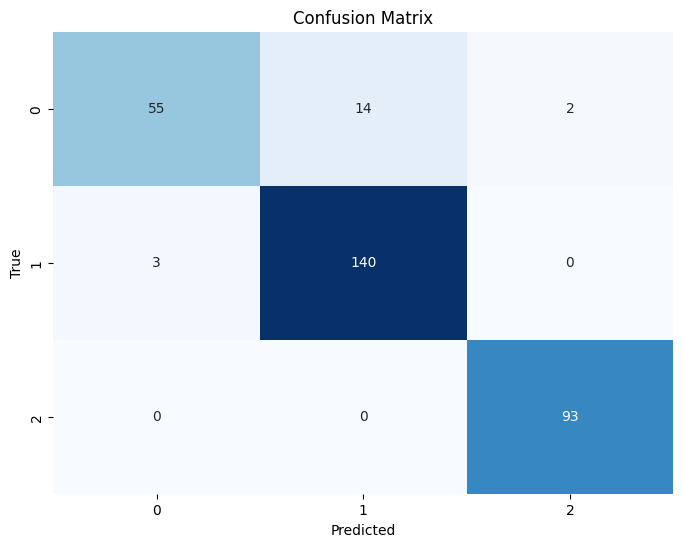

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")